In [ ]:
# %pip install -q rasterio
# %pip install -q rio-cogeo
# %pip install -q owslib
# %pip install -q rioxarray
# %pip install -q geopandas
# %pip install -q folium

In [1]:
from maap.maap import MAAP
maap = MAAP()
import json
from IPython.display import display, Image
import ipycmc
w = ipycmc.MapCMC()
from pprint import pprint
import rasterio as rio
from rasterio.plot import show
import requests
import os
from owslib.wcs import WebCoverageService
import rioxarray
import geopandas as gpd
import warnings
import folium
warnings.filterwarnings('ignore')

# MAAP DATA SYSTEM DEMO FOR V1D2

## Responding to the Usability Study and UWG Needs

### Recommendations from the Usability Study

* Create additional documentation
* Allow users to visualize data on a map
* Help users deal with large amounts of data

## Demo Outline:

* Demonstrate using **documenation** to:
  - query by additional attributes
  - visualize data on a map
* Demonstrating how we help users deal with **large amounts of data** using cloud-optimized formats and OGC standards
    * SRTM
      - Visualization - WMTS with the Dynamic Tiler API + MAAP API
      - Query - WCS via EDAV
    * ATL08
      - Visualization - 3D Tiles 
      - Query - Features
 

# Using Documentation

We can use [Searching by Additional Attributes](https://maap-project.readthedocs.io/en/latest/search/granules.html?highlight=additional#Searching-by-Additional-Attributes) documentation to search by the requested additional attributes `direction` and `polarization`.

In [2]:
results = maap.searchGranule(orbit_dir = "ASCENDING", limit=100)
pprint(f'Got {len(results)} results')
# print(json.dumps(results[0], indent=2))

'Got 100 results'


In [4]:
results = maap.searchGranule(polarization = "HH", limit=100)
pprint(f'Got {len(results)} results')
# print(json.dumps(results[0], indent=2))

'Got 100 results'


We can use [Visualizing Web Map Tile Service (WMTS) Layers
](https://maap-project.readthedocs.io/en/latest/visualization/using_pycmc.html) documentation to visualize data on a map.

In [5]:
# Import the ipycmc module
import ipycmc
# utilize the CMC widget
w = ipycmc.MapCMC()
w

MapCMC()

In [6]:
w.load_layer_config("https://api.maap-project.org/api/wmts/GetCapabilities", "wmts/xml")

# Handling Large Amounts of Data

## SRTM Cloud-Optimized GeoTiffs (COGs)

SRTM (Shuttle Radar Topography Mission) obtained elevation data on a near-global scale using radar interferometry. The SRTMGL1 contains elevation data in 1° X 1° tiles at 1 arc second (about 30 meters) resolution.

During this delivery, SRTMGL1 data product was made available in **Cloud-Optimized GeoTiff (COG)** format so that it can be dynammically visualizaed on a MAAP alongside the previoously published COGs of UAVSAR and LVIS.

## SRTM Visualization

In [8]:
results = maap.searchGranule(short_name="SRTMGL1_COD", bounding_box="7.27,-5.24,17.00,3.48")
for r in results:
    granule_ur = r['Granule']['GranuleUR']
    w.load_layer_config(f"https://api.maap-project.org/api/wmts/GetCapabilities?granule_ur={granule_ur}", "wmts/xml")

## Querying SRTM using WCS

Let's send a request to the EDAV WCS and extract a subset of the data in GeoTiff format and save it to our workspace.

In [10]:
# Configure the WCS source
EDAV_WCS_Base = "https://edav-wcs.adamplatform.eu/wcs"
wcs = WebCoverageService(f'{EDAV_WCS_Base}?service=WCS', version='2.0.0')

# Request the data from WCS
response = wcs.getCoverage(
    identifier=['uavsar_AfriSAR_v1_SLC'],
    format='image/tiff',
    filter='false',
    scale=1,
    subsets=[('Long',11.6,11.7),('Lat',-0.2,-0.1)]
)

# Save the results to file as a tif
results = "EDAV_example.tif"
with open(results, 'wb') as file:
    file.write(response.read())

Do a quick check that the data is valid, and contains spatial metadata. For fun we can check if it's a Cloud Optimized Geotiff.

In [11]:
!gdalinfo {results}
!rio cogeo validate {results}

Driver: GTiff/GeoTIFF
Files: EDAV_example.tif
Size is 709, 709
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (11.599925815140329,-0.099890569280316)
Pixel Size = (0.000141205421952,-0.000141205421952)
Metadata:
  AREA_OR_POINT=Area
  OVR_RESAMPLING_ALG=BILINEAR
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  11.5999258,  -0.0998906) ( 11d35'59.73"E,  0d 5'59.61"S)
Lower Left  (  11.5999258,  -0.2000052) ( 11d35'59.73"E,  0d12' 0.02"S)
Upper Right (  11.7000405,  -0.0998906) ( 11d42' 0.15"E,  0d 5'59.61"S)
Lower Right (  11.7000405,  -0.2000052) ( 11d42' 0.15"E,  0d12' 0.02"S)
Center      (  11.6499831,  -0.1499479) ( 11d38'59.94"E,  0d 8'59.81"S)
Band 1 Block=709x1 Type=Float64, ColorInterp=Gray
  N

### Read the data and do some quick visual exploration.

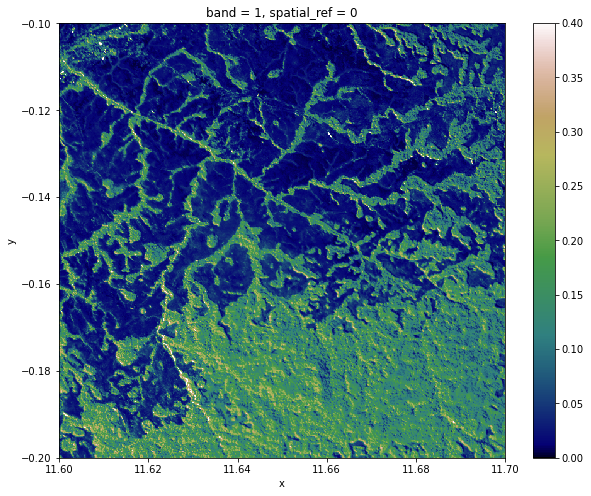

In [12]:
edav_x = rioxarray.open_rasterio(results)
edav_x.plot(cmap="gist_earth", figsize=(10, 8)).set_clim(0, 0.4)

# Handling Large Amounts of (Point Cloud) Data (Continued)

## ATL08 v003 Entwine Point Tiles (EPT)

During V1D2, the data team made the ATL08 IceSAT-2 Dataset available in [Entwine Point Tile (EPT)](https://entwine.io/entwine-point-tile.html) format.

### What are Entwine Point Tiles?

Entwine Point Tiles are a cloud-optimized octree data format for storing and visualizing massive point clouds efficiently. This format is gaining a lot of momentum and interest with an active development community.


### Visualizing with potree

Potree is a tool for visualizing EPT stores directly.

https://potree.entwine.io/data/view.html?r=%22https://cumulus-map-internal.s3.amazonaws.com/file-staging/nasa-map/ATL08_ARD-beta___001/global/ept%22

In [13]:
img_src = "images/Oct-28-2020 16-41-44.gif"
Image(url = img_src)

### Visualizing with the 3D Tiles Service (OGC)

Cesium is a 3D tool which can be used to visualize point clouds alongside 2D data using a 3D Tiles Service.

* [3D Tiles API Endpoint](https://api.maap.xyz/api/3d-tiles/ATL08_ARD-beta___001/global/ept/ept-tileset/tileset.json)
* [Demo using Cesium](http://cesium.entwine.io/?url=https://api.maap.xyz/api/3d-tiles/ATL08_ARD-beta___001/global/ept/ept-tileset/tileset.json)

In [14]:
img_src = "images/Oct-28-2020 16-53-01.gif"
Image(url = img_src)

### Visualizing with ipyCMC

In [19]:
w.load_layer_config("https://cmr.maap-project.org/search/concepts/G1200354094-NASA_MAAP.json", "json", {"handleAs": "vector-3d-tile"})

## Querying ATL08 EPT using the Features Service

We can use the features service for some basic querying of the EPT Store.

### Query By Bounding Box

In [15]:
# Format a request to the API
api_url = "https://obnrh8ozt0.execute-api.us-east-2.amazonaws.com/collections/Global/items"

# bbox should be defined as xmin, xmax, (min value z), ymin, ymax, (max value z)
# Make a request for a bounding box over Peru
bbox="-77,-26,300,-73,0,500"

payload = {
    "f": "json",
    "limit": 100,
    "bbox": bbox,
}

r = requests.get(api_url, params = payload)

In [16]:
# Get the results directly into a Geo Data Frame (saving to file not required but recommended)
api_geojson = r.json()
api_geojson.keys()
adf = gpd.GeoDataFrame.from_features(api_geojson["features"], crs='epsg:4326')
adf.head()

,geometry,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,...,GpsTime,Red,Green,Blue,ScanChannel,ClassFlags,ElevationLow,HeightAboveGround,OffsetTime,OriginId
0,POINT Z (-73.84000 -7.06000 439.42000),-73.84,-7.06,439.42,0.0,1.0,1.0,0.0,0.0,0.0,...,1.268897e+09,29.0,108.0,112.0,0.0,0.0,500.633,57.154,70097075.0,76803.0
1,POINT Z (-73.85000 -11.24000 307.25000),-73.85,-11.24,307.25,0.0,1.0,1.0,0.0,0.0,0.0,...,1.271398e+09,13.0,97.0,102.0,0.0,0.0,314.104,33.405,72597704.0,81221.0
2,POINT Z (-75.58000 -8.80000 310.06000),-75.58,-8.80,310.06,0.0,1.0,1.0,0.0,0.0,0.0,...,1.240313e+09,10.0,95.0,101.0,0.0,0.0,289.127,42.708,41512918.0,29028.0
3,POINT Z (-74.17000 -11.57000 471.59000),-74.17,-11.57,471.59,0.0,1.0,1.0,0.0,0.0,0.0,...,1.245357e+09,27.0,107.0,111.0,0.0,0.0,488.210,25.316,46556779.0,37945.0
4,POINT Z (-73.48000 -10.88000 329.13000),-73.48,-10.88,329.13,0.0,1.0,1.0,0.0,0.0,0.0,...,1.258205e+09,25.0,106.0,110.0,0.0,0.0,314.425,35.354,59404688.0,58028.0


In [17]:
m = folium.Map(
    location=[adf.centroid[0].y, adf.centroid[0].x],
    zoom_start=10,
    tiles='Stamen Terrain'
)


folium.GeoJson(
    adf,
    name = "geojson"
).add_to(m)

m

### Query by Granule Id

In [18]:
granule_id = 'ATL08_20181014035224_02370107_003_01'
payload = {
    "f": "json",
    "origin": granule_id,
}

r = requests.get(api_url, params = payload)
api_geojson = r.json()
api_geojson.keys()
adf = gpd.GeoDataFrame.from_features(api_geojson["features"], crs='epsg:4326')
adf.head()

,geometry,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,...,GpsTime,Red,Green,Blue,ScanChannel,ClassFlags,ElevationLow,HeightAboveGround,OffsetTime,OriginId
0,POINT Z (-4.89000 11.43000 384.35000),-4.89,11.43,384.35,0.0,1.0,1.0,0.0,0.0,0.0,...,1.223525e+09,255.0,230.0,201.0,0.0,0.0,378.868,10.194,24724588.0,24.0
1,POINT Z (-4.97000 11.26000 402.93000),-4.97,11.26,402.93,0.0,1.0,1.0,0.0,0.0,0.0,...,1.223525e+09,255.0,221.0,191.0,0.0,0.0,401.890,8.355,24724590.0,24.0
2,POINT Z (-4.96000 11.09000 496.87000),-4.96,11.09,496.87,0.0,1.0,1.0,0.0,0.0,0.0,...,1.223525e+09,255.0,160.0,121.0,0.0,0.0,496.675,9.610,24724593.0,24.0
3,POINT Z (-4.97000 10.92000 559.00000),-4.97,10.92,559.00,0.0,1.0,1.0,0.0,0.0,0.0,...,1.223525e+09,255.0,117.0,73.0,0.0,0.0,557.005,11.124,24724595.0,24.0
4,POINT Z (-4.97000 10.66000 342.99000),-4.97,10.66,342.99,0.0,1.0,1.0,0.0,0.0,0.0,...,1.223525e+09,251.0,242.0,217.0,0.0,0.0,344.449,6.784,24724600.0,24.0


## More query options with pdal

The [documentation](https://maap-project.readthedocs.io/en/latest/query/testing-ept-stores.html#PDAL-Pipelines) provides additional options for how to query with PDAL (Point Cloud Data Abstraction Library).

# Thank You!

**Big thanks to** Aaron Kaulfus, Alex Mandel, Chuck Daniels, David Bitner, Hai, Kaylin Bugbee, Slesa, Sam Ayers and Seth Vincent with whom none of this would be possible.